
###      Part 1: Implementation
#### Neuroevolution: Neural Architecture Search (NAS)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np

EPS = 1.0e-7


#### CNN helpers




In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        if x.shape[1] != np.prod(self.size):
            print("x.shape[1], np.prod(self.size)")
            print(x.shape[1], np.prod(self.size))
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        self.classnet = classnet
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Apply the classification network
        logits = self.classnet(x)
        # Compute the predicted class label
        _, y_pred = torch.max(logits, dim=1)


        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):

        # Apply the classification network
        logits = self.classnet(x)
        # Compute the negative log-likelihood loss
        loss = self.nll(logits, y)

        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()


#### Training & evaluation functions


In [3]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, verbose=False):
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        N = N + test_batch.shape[0]
    loss_test = loss_test / N
    loss_error = loss_error / N

    if epoch is None:     # Print the performance
        if verbose:
            print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            if verbose:
                print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, verbose=False
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    e = 0
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # zero gradients
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e, verbose=verbose)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

#### Dataset preparation


In [4]:
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


#### Helper function to build tourch nn module dynamically

In [5]:
def build_model(gen: np.array, D=64, K=10) -> nn.Sequential:
    """
    Dynamically build the sequential model using gen: a numpy array of shape (7,) which each position
    follows instruction per Part 1, Neuroevolution for NAS, item 1.
    D is the number of feature of the images, while K is the number of labels in the digits.
    """
    im_size = int(np.sqrt(D))

    # set number of kernels, based on gen[0]
    num_kernels = {0: 8, 1: 16, 2: 32}[gen[0]]

    # set kernel size based on gen[1]
    if gen[1] == 0:
        kernel_size = 3
        conv2d_layer = nn.Conv2d(1, num_kernels, kernel_size=(kernel_size, kernel_size), padding=1, stride=1)
    elif gen[1] == 1:
        kernel_size = 5
        conv2d_layer = nn.Conv2d(1, num_kernels, kernel_size=(kernel_size, kernel_size), padding=2, stride=1)
    else:
        raise Exception("Pos 1")
    # Choose activation function based on gen[2]
    if gen[2] == 0:
        f0 = nn.ReLU()
    elif gen[2] == 1:
        f0 = nn.Sigmoid()
    elif gen[2] == 2:
        f0 = nn.Tanh()
    elif gen[2] == 3:
        f0 = nn.Softplus()
    elif gen[2] == 4:
        f0 = nn.ELU()
    else:
        raise Exception("Pos 2")
    
    # Choose pooling method based on gen[3] (is there pooling) and gen[4] (what kind of pooling)
    if gen[3] == 0:
        if gen[4] == 0:
            pool_layer = nn.AvgPool2d(kernel_size=(2, 2))
        elif gen[4] == 1:
            pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
        else:
            raise Exception("Pos 4")
    elif gen[3] == 1:
        pool_layer = nn.Identity()
    else:
        raise Exception("Pos 3")
    
    # Set number of neurons in the fully connected layer based on gen[5]
    num_neurons_dict = {k: v for k, v in enumerate(range(10,110,10))}
    num_neurons = num_neurons_dict[gen[5]]

    # Choose activation function based on gen[6]
    if gen[6] == 0:
        f1 = nn.ReLU()
    elif gen[6] == 1:
        f1 = nn.Sigmoid()
    elif gen[6] == 2:
        f1 = nn.Tanh()
    elif gen[6] == 3:
        f1 = nn.Softplus()
    elif gen[6] == 4:
        f1 = nn.ELU()
    else:
        raise Exception()

    # Construct network with selected features
    classnet = nn.Sequential(
        Reshape((1, im_size, im_size)),  # Reshape the input data
        conv2d_layer,  # Convolutional layer
        f0,  # Activation function
        pool_layer,  # Max pooling layer
        nn.Flatten(),  # Flatten the tensor for fully connected layers
        nn.LazyLinear(num_neurons),  # Hidden layer
        f1,
        nn.Linear(num_neurons, K),  # Output layer
        nn.LogSoftmax(dim=1)  # Log softmax activation for output probabilities
    )  # ------

    return classnet



#### EA Classes

Repressilator class is recycled from previous assignment with the following changes:
- 3 dataloaders are class members
- gen (individual representation) is holded in params member
- solve_repressilator method is used for model training
- loss method is used for model prediction

In [7]:


class EA(object):
    def __init__(self, pop_size, bounds_min, bounds_max,
                 training_loader, val_loader, test_loader, hparams: np.array):
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        self.prob_mutation = 0.25
        self.hparams = hparams
        self.ind = None
        self.data_container = {
            'training_loader': training_loader,
            'val_loader': val_loader,
            'test_loader': test_loader
        }

        result_dir = os.path.join(hparams['result_dir'], "results", hparams['name'] + "/")
        if not (os.path.exists(result_dir)):
            os.makedirs(result_dir)
        self.result_dir = result_dir

    def parent_selection(self, x_old, f_old):
        # Tournament selection
        tournament_size = 2  
        pot_parent_lineup = np.random.randint(0, len(x_old), size=(
        self.pop_size, tournament_size))  # select 2 individuals, 100 times -> 2D array of 100 rows and 2 columns
        index_best = np.argmin(f_old[pot_parent_lineup],axis=1)  # individual with the lowest fitness 
        x_parents = x_old[pot_parent_lineup[np.arange(self.pop_size), index_best], :]  # stores winner parents
        f_parents = f_old[pot_parent_lineup[np.arange(self.pop_size), index_best]]  # stores fitness of winner parents
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):
        # Discrete recombination
        num_parents = x_parents.shape[0]  
        num_genes = x_parents.shape[1]  
        x_children = np.zeros_like(x_parents)  
        for first_parent in range(num_parents):  # loops through each parent in the input x_parents
            p_indexes = np.arange(num_parents) 
            p_indexes = np.delete(p_indexes,first_parent)  # removes the current parent's index i from the array 
            second_parent = np.random.choice(p_indexes)  # selects another parent at random from the remaining 
            mask = np.random.randint(0, 2, size=num_genes).astype(bool)  # creates a binary "mask" array 
            x_children[first_parent, mask] = x_parents[
                first_parent, mask]  
            x_children[first_parent, ~mask] = x_parents[
                second_parent, ~mask]  
        return x_children

    def mutation(self, x_children):  # mutate them randomly, small change, exploitation
        # Gaussian mutation

        prob_mutation = self.prob_mutation  
        x_mutation = np.random.uniform(size=x_children.shape) < prob_mutation  # T/F values, randomly sampling from a uniform distribution of the same shape as x_children.
        r = np.random.randint(low=self.bounds_min, high=self.bounds_max, size=x_children.shape)
        x_children = x_children.copy()  # x_children variable is then copied
        x_children[x_mutation] = r[x_mutation]  #  where x_mutation is True, r is added to the original value of the gene.

        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # Mu + lambda selection
        x = np.concatenate([x_old,x_children])  # Concatenates the old population (x_old) with the children population (x_children) 
        f = np.concatenate([f_old, f_children])  # Concatenates the old fitness (f_old) with the children fitness (f_children) 
        idxs = np.argsort(f)[:self.pop_size]  # Sorts the combined fitness array 
        x = x[idxs, :]  # stores top 100
        f = f[idxs]  # stores the fitness values of the top 100

        return x, f

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):  # already made function to evaluate a new child
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.ind = xi.copy()
                name = self.result_dir + self.hparams['name']

                _, _ = self._train_model(name=name)
                objective_values.append(self.loss(name=name))

            objective_values = np.asarray(objective_values)
        else:
            self.ind = x.copy()
            name = self.hparams['name']

            _, _ = self._train_model(name=name)
            objective_values = self.loss(name=name)

        return objective_values

    def _train_model(self, name):  # Model training.
        gen = self.ind
        training_loader = self.data_container['training_loader'];
        val_loader = self.data_container['val_loader']

        classnet1 = build_model(gen)
        model = ClassifierNeuralNet(classnet1)

        optimizer = torch.optim.Adamax(
            [p for p in model.parameters() if p.requires_grad == True],
            lr=self.hparams['lr'], weight_decay=self.hparams['weight_decay'],
        )

        nll_val, error_val = training(
            name=name,
            max_patience=self.hparams['max_patience'],
            num_epochs=self.hparams['num_epochs'],
            model=model,
            optimizer=optimizer,
            training_loader=training_loader,
            val_loader=val_loader,
        )

        return nll_val, error_val

    # Calculating the objective function.
    def loss(self, name):
        test_loader = self.data_container['test_loader']
        _, test_error = evaluation(name=name, test_loader=test_loader)

        num_kernels = self.hparams['num_kernels']
        Np = num_kernels[self.ind[0]]
        Nmax = max(num_kernels.values())
        curr_loss = test_error + self.hparams['lambda'] * Np / Nmax

        return curr_loss

    def step(self, x_old, f_old):
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
        return x, f

#### Main loop

In [8]:
num_generations = 20  # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [0, 0, 0, 0, 0, 0, 0]
bounds_max = [2, 1, 4, 1, 1, 9, 4]


# Initialize the repressilator
hparams = {
    'K': 10, # The number of labels.
    'result_dir': "./",  # (current folder)
    'name': 'classifier_cnn', # Just a name to identify the models.
    'max_patience': 4, # early stopping parameter. 
    'num_epochs': 10,  # The resource for each training.
    'lr': 1e-3, # The learning rate parameter.
    'weight_decay': 1e-5, # and weight decay parameter.
    'lambda': 0.01, 
    'num_kernels': {0: 8, 1: 16, 2: 32},
}

In [9]:
ea = EA(pop_size, bounds_min, bounds_max,
            training_loader, val_loader, test_loader, hparams=hparams)
# Init the population
curr_popupation = np.random.randint(low=bounds_min, high=bounds_max, size=(pop_size, len(bounds_min)))

fitness = ea.evaluate(curr_popupation)

# Gather populations and values of the best candidates to further
# analyze the algorithm.
populations = [] # A collector list.
populations.append(curr_popupation) # Keep a copy of the population in the collector.
fitness_best = [fitness.min()]

# Run the EA.
for i in range(num_generations): # Loop for each generation
    if i % int(num_generations * 0.1) == 0: # One time every 10 generations, print population best fitness.
        print("Generation: {}, best fitness: {:.2f}".format(i, fitness.min()))
    curr_popupation, fitness = ea.step(curr_popupation, fitness) # Evolute current population.
    populations.append(curr_popupation.copy()) # Keep a copy of the population in the collector.
    if fitness.min() < fitness_best[-1]: # Append the current best.
        fitness_best.append(fitness.min())
    else:
        fitness_best.append(fitness_best[-1])
print("FINISHED!")

Generation: 0, best fitness: 0.10
Generation: 2, best fitness: 0.10
Generation: 4, best fitness: 0.09
Generation: 6, best fitness: 0.09
Generation: 8, best fitness: 0.09
Generation: 10, best fitness: 0.09
Generation: 12, best fitness: 0.08
Generation: 14, best fitness: 0.08
Generation: 16, best fitness: 0.08
Generation: 18, best fitness: 0.08
FINISHED!


The convergence plot: the best value of the fitness function for each generation

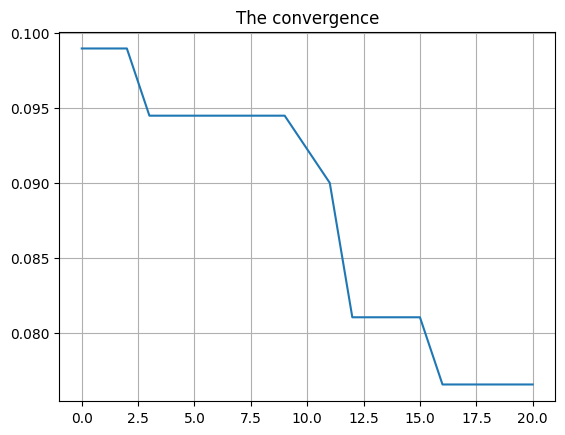

In [10]:
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(fitness_best)), fitness_best)
plt.title("The convergence")
plt.grid()

### Part 2: Analysis

In [11]:
# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [13]:
best_gen = populations[-1][0]
name = hparams['result_dir'] + hparams['name']


classnet1 = build_model(best_gen)
model = ClassifierNeuralNet(classnet1)

optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=hparams['lr'], weight_decay=hparams['weight_decay'],
)

nll_val, error_val = training(
    name=name,
    max_patience=12,
    num_epochs=1000,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
    verbose=True,
)

test_loss, test_error = evaluation(name=name, test_loader=test_loader)

Epoch: 0, val nll=1.561106229509626, val ce=0.22857142857142856
Epoch: 10, val nll=0.2874520356314523, val ce=0.037142857142857144
Epoch: 20, val nll=0.18507333755493163, val ce=0.037142857142857144
Epoch: 30, val nll=0.13703822885240827, val ce=0.025714285714285714
Epoch: 40, val nll=0.12429344517844064, val ce=0.025714285714285714
Epoch: 50, val nll=0.10788037061691284, val ce=0.02
Epoch: 60, val nll=0.09471360308783396, val ce=0.017142857142857144
Epoch: 70, val nll=0.09134088805743626, val ce=0.022857142857142857
Epoch: 80, val nll=0.08791085481643676, val ce=0.02
Epoch: 90, val nll=0.0858834079333714, val ce=0.022857142857142857
Epoch: 100, val nll=0.08078931178365435, val ce=0.02
Epoch: 110, val nll=0.07983788098607744, val ce=0.02
Epoch: 120, val nll=0.07799937776156834, val ce=0.02
Epoch: 130, val nll=0.07550032317638397, val ce=0.02
Epoch: 140, val nll=0.07456803849765233, val ce=0.02


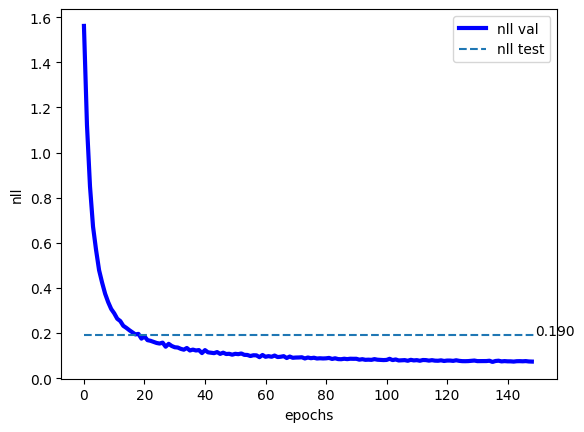

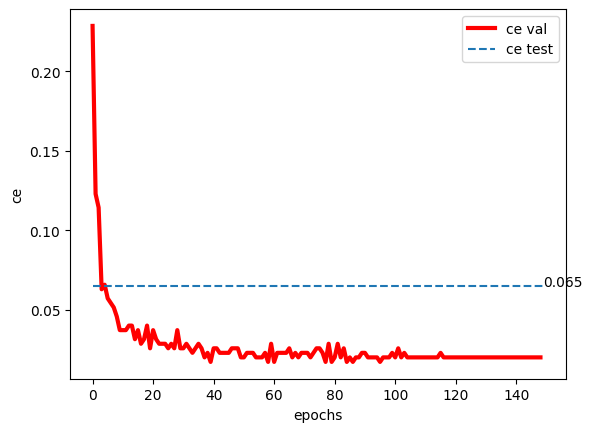

In [14]:
# write the results to a file
f = open(name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)